# Analisis de la movilidad urbana utilizando estadisticas del Comoir

En este notebook intento realizar un analisis geoespacial de la movilidad urbana utilizando como fuente de datos las estadisticas de uso de la aplicacion Comoir publicadas por la IMM.

Primero lo primero - Las librerias que voy a precisar!

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import shapely
from pyproj import Proj, transform
import os
import sys
import zipfile
from six.moves.urllib.request import urlretrieve

%matplotlib inline

## Algunas cosas que voy a precisar luego

Defino algunas constantes que me van a servir a lo largo del notebook. Dado que los archivos con los datos son unos cuantos y ocupan en total cerca de 1 GB, en lugar de subirlos a github, utilizo algunas funciones que tome prestadas de un curso sobre TensorFlow para descargar los archivos en caso de ser necesarios.

In [2]:
SEPARADOR = ';'
AÑO = 2011

urlGis = 'http://intgis.montevideo.gub.uy/sit/tmp/'
urlImm = 'http://www.montevideo.gub.uy/sites/default/files/datos/'

last_percent_reported = None

data_dict = {2010:('../data/comoir','comoir_2010_01_12.csv.gz'), 
             2011:('../data/comoir','comoir_2011_01_12.csv.gz'), 
             2012:('../data/comoir','comoir_2012_01_12.csv.gz'), 
             2013:('../data/comoir','comoir_2013_01_12.csv.gz'), 
             2014:('../data/comoir','comoir_2014_01_06.csv.gz')}

barrios_shp_path = '../data/barrios_limites/barrios.shp' #shapefile con los barrios de montevideo
vias_shp_path = '../data/v_mdg_vias/v_mdg_vias.shp' #shapefile con las vias (calles, caminos, pasajes, etc.) de mvdeo
destino_shp_path = '../data/v_uptu_lsv_destinos/v_uptu_lsv_destinos.shp' #shapefile con los destino... ni se porque lo baje
ejes_shp_path = '../data/ejesinv/ejesinv.shp' # ejes de las calles. Tiene todas llas "cuadras" de cada calle.
codpost_shp_path = '../data/cpost/cpost.shp' # poligonos de los distintos codigos postales de montevideo 

manzanas_shp_path = '../data/v_mdg_manzanas/v_mdg_manzanas.shp' #shapefile con las manzanas
accesos_shp_path = '../data/v_mdg_accesos/v_mdg_accesos.shp' #shapefile con las calles y su numeracion. 
cultura_csv_path = '../data/v_uptu_lugares/uptu_cultura.zip' #shapefile con la ubicacion de los centros culturales
deporte_csv_path = '../data/v_uptu_lugares/uptu_deporte.csv.gz' #shapefile con los lugares centros deportivos
educacion_csv_path = '../data/v_uptu_lugares/uptu_educacion.csv.gz' #shapefile con los centros educativos 
patrimonio_csv_path = '../data/v_uptu_lugares/uptu_patrimonio.csv.gz' #shapefile con los lugares patrimoniales
playa_csv_path = '../data/v_uptu_lugares/uptu_playa.csv.gz' #shapefile con las playas
salud_csv_path = '../data/v_uptu_lugares/uptu_salud.csv.gz' #shapefile con los centros de salud
espacios_shp_path = '../data/v_mdg_espacios_libres/v_mdg_espacios_libres.shp' #shapefile de espacios libres (parques, plazas, etc)
monumentos_shp_path = '../data/v_mdg_ubicaciones_notables/v_mdg_ubicaciones_notables.shp' #shapefile de monumentos

---
Estas funciones sirven para descargar los archivos en forma progresiva; despues de todo no todos tenemos la misma velocidad de conexion.


In [3]:
def download_progress_hook(count, blockSize, totalSize):
    """ 
        A hook to report the progress of a download. This is mostly intended 
        for users with slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(url, filename, directory, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(directory, filename)
    os.makedirs(name=directory, exist_ok=True) # Attempt to create the dir where the file should be downloaded to. If exists then do nothing
    if force or not os.path.exists(dest_filename):
        print('Iniciando Descarga:', url + filename) 
        try:
            filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
            print('Descarga Completa!')
        except:
            print('%s no se pudo descargar!' % filename)
    else:
        print('%s ya existe en la carpeta - Salteando la descarga.' % dest_filename) 
    
    return dest_filename

def maybe_extract(filename, destination, force=False):
    root = os.path.splitext(filename)[0]  # remove extension .gz, .zip
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s ya existe - Salteando la extraccion.' % root) 
    else:
        print('Descomprimiendo %s. Puede tomar unos minutos. Por favor espere.' % root) 
        gz = zipfile.ZipFile(filename)
        sys.stdout.flush()
        gz.extractall(destination)

        gz.close()

---

Esta funcion la utilizare mas adelante para descomponer un shapely.Point en sus coordenadas x e y.

In [4]:
def get_point(punto):
    if isinstance(punto, shapely.geometry.Point):
        return punto
    elif isinstance(punto, shapely.geometry.MultiPoint):
        return punto.centroid
    else:
        return np.nan

In [5]:
filename = maybe_download(urlImm, 'uptu_cultura.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_deporte.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_educacion.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_patrimonio.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_playa.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_salud.zip', '../data/v_uptu_lugares')

filename = maybe_download(urlImm, 'barrios_limites.zip', '../data')
maybe_extract(filename, destination='../data/barrios_limites')

filename = maybe_download(urlGis, 'v_mdg_vias.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_vias')

filename = maybe_download(urlGis, 'v_mdg_accesos.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_accesos')

filename = maybe_download(urlGis, 'v_mdg_ubicaciones_notables.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_ubicaciones_notables')

filename = maybe_download(urlGis, 'v_mdg_espacios_libres.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_espacios_libres')

#filename = maybe_download(urlImm, 'comoir_2010_01_12.csv.gz', '../data/comoir')
filename = maybe_download(urlImm, data_dict[AÑO][1], data_dict[AÑO][0])

../data/v_uptu_lugares/uptu_cultura.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_deporte.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_educacion.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_patrimonio.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_playa.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_salud.zip ya existe en la carpeta - Salteando la descarga.
../data/barrios_limites.zip ya existe en la carpeta - Salteando la descarga.
../data/barrios_limites ya existe - Salteando la extraccion.
../data/v_mdg_vias.zip ya existe en la carpeta - Salteando la descarga.
../data/v_mdg_vias ya existe - Salteando la extraccion.
../data/v_mdg_accesos.zip ya existe en la carpeta - Salteando la descarga.
../data/v_mdg_accesos ya existe - Salteando la extraccion.
../data/v_mdg_ubicaciones_notables.zip ya existe en la carpeta - 

## La estrategia

Los datos con las estadisticas estan separados en 1 archivo por año. Del 2010 al 2013 inclusive, contienen la información de todo el año, mientras que el 2014 solo incluye información del primer semestre de ese año. Las busquedas que se pueden hacer en Comoir son de 3 tipos por cada punto del recorrido (origen y destino) lo que da un total de 6 tipos diferentes combinados. Las busquedas pueden hacerse por:
    - Esquina: curce de calles
    - Dirección: calle y número
    - Lugar de interés

Cada csv indica el tipo de origen, el tipo de destino, y para cada uno de ellos se indica 1 o 2 códigos. Si el tipo del punto es dirección o lugar de interes, el código identifica la calle o el lugar de interes respectivamente. Si el tipo del punto es esquina, se indican dos codigos, donde el primero identifica una calle y el segundo la otra. Los códigos hacen referencia a los otros shapefile, para las calles se hace referencia a vias_shp_path, y para lugares de interes se hace referencia a cultura_shp_path, deporte_shp_path, educacion_shp_path, patrimonio_shp_path, playa_shp_path, salud_shp_path, espacios_shp_path y monumentos_shp_path. Para las direcciones numeradas (calle y numero de puerta) se hace referencia al shapefile accesos_shp_path.

Las consultas de los usuarios indican solamente el codigo del origen y el codigo del destino pero no proveen datos sobre la ubicacion de dichos puntos. Para poder obtener esta informacion tenemos que hacer un join entre las consultas y cada una de "las codigueras" para poder agregarle la informacion faltante.
Como mencionaba antes cada punto particular pertenece a uno de 3 grandes conjuntos: lugares de interes, esquina o direccion. Para cada punto la estrategia a seguir es diferente.

Los lugares de interes son los mas simples ya que el codigo los identifica y a este se le asocian las coordenadas que lo ubican en el mapa. Para agregar las coordenadas a las consultas de los lugares de interes simplemente hacemos un join entre ambos dataframes (el de consultas y el de lugares de interes). Las direcciones no son tan simples ya que el codigo identifica la calle pero a esto se suma el numero de puerta. En el shapefile *accesos_shp_path* se encuentran todas las direcciones de montevideo. Es decir, todas las calles y numeros de puerta existentes con su ubicacion geografica correspondiente. En este caso la estrategia sera quedarnos unicamente con las direcciones que realmente fueron consultadas (es decir, las diferentes combinaciones de calle y nro de puerta consultada) y luego hacer un merge entre estas y las consultas para asociar a cada una de ellas las coordenadas.

Por ultimo las esquinas, las mas dificiles de los tres. En este caso el shapefile *vias_shp_path* tiene todas las calles de montevideo donde cada una de ellas es una conjunto de LineString. En este caso la estrategia sera similar a la anterior pero con alguna variante; obtenemos todas las esquinas diferentes consultadas, es decir todos los pares distintos de codigo_destino_1 y codigo_destino_2 que aparezcan en las consultas. Luego hacemos un merge de este resultado con el conjunto de todas las calles para saber cuales son los LineString que conforman cada una de ellas. Finalmente intersectamos cada una de las calles para obtener el punto correspondiente a la esquina y hacemos un merge con las consultas para asociar a cada destino el punto correspondiente en el mapa.

In [6]:
#Levanto los lugares de interes y agrego a cada dataframe el tipo y las coordenadas (x,y)
cu = pd.read_csv(cultura_csv_path, delimiter=SEPARADOR)      #cultura         - tipo 3
de = pd.read_csv(deporte_csv_path, delimiter=SEPARADOR)      #deporte         - tipo 4
ed = pd.read_csv(educacion_csv_path, delimiter=SEPARADOR)    #educacion       - tipo 5
pa = pd.read_csv(patrimonio_csv_path, delimiter=SEPARADOR)   #patrimonio      - tipo 9
pl = pd.read_csv(playa_csv_path, delimiter=SEPARADOR)        #playa           - tipo 10
sa = pd.read_csv(salud_csv_path, delimiter=SEPARADOR)        #salud           - tipo 11
el = gpd.read_file(espacios_shp_path)   #espacios libres - tipo 6 espacio libre
pq = el[np.isfinite(el['COD_NOM_PA'])]  #parques         - tipo 7
el = el[np.isfinite(el['COD_NOM_ES'])]  #espacio libre   - tipo 6
mo = gpd.read_file(monumentos_shp_path) #monumentos      - tipo 8

cu.loc[:,'tipo'] = 3
de.loc[:,'tipo'] = 4
ed.loc[:,'tipo'] = 5
pa.loc[:,'tipo'] = 9
pl.loc[:,'tipo'] = 10
sa.loc[:,'tipo'] = 11
el.loc[:,'tipo'] = 6
el.loc[:,'codigo'] = el['COD_NOM_ES'].apply(lambda c: c)
#el.loc[:,'x'] = el['geometry'].apply(lambda p: p.centroid.x)
#el.loc[:,'y'] = el['geometry'].apply(lambda p: p.centroid.y)
el.loc[:,'punto'] = el['geometry'].apply(lambda p: p.centroid)
pq.loc[:,'tipo'] = 7
pq.loc[:,'codigo'] = pq['COD_NOM_PA'].apply(lambda c: c)
#pq.loc[:,'x'] = pq['geometry'].apply(lambda p: p.centroid.x)
#pq.loc[:,'y'] = pq['geometry'].apply(lambda p: p.centroid.y)
pq.loc[:,'punto'] = pq['geometry'].apply(lambda p: p.centroid)
#mo.loc[:,'x'] = mo['geometry'].apply(lambda p: p.x)
#mo.loc[:,'y'] = mo['geometry'].apply(lambda p: p.y)
mo.loc[:,'punto'] = mo['geometry'].apply(lambda p: p)
mo = mo.dropna(subset=['COD_NOM_UB'])
mo.loc[:,'tipo'] = 8
mo.loc[:,'codigo'] = mo['COD_NOM_UB'].apply(lambda c: c)

In [7]:
#Unifico todos los lugares de interes en un solo dataframe con el codigo, tipo y las coordenadas (x,y) de cada uno.
lugares_interes = cu.append(de.append(ed.append(pa.append(pl.append(sa.append(pq.append(el.append(mo,ignore_index=True),
                                                                              ignore_index=True),
                                                                    ignore_index=True),
                                                          ignore_index=True),
                                                ignore_index=True),
                                      ignore_index=True), 
                            ignore_index=True), 
                  ignore_index=True)
lugares_interes = lugares_interes[['codigo', 'tipo', 'punto']]

In [8]:
#Levanto las "cuadras" de cada calle y las agrupo por codigo para luego unir todas las cuadras de cada calle en una sola coleccion
calles = gpd.read_file(vias_shp_path) 
calles = calles.groupby('COD_NOMBRE')['geometry'].agg({'geometry': lambda x: shapely.ops.linemerge(x.values)})
calles.loc[:,'codigo'] = calles.index
calles.loc[:,'tipo'] = 1

In [9]:
#Levanto las calles con su numeracion
c_nums = gpd.read_file(accesos_shp_path) 
c_nums.loc[:,'direccion'] = c_nums['NOM_CALLE'] + ' ' + c_nums['NUM_PUERTA'].map(str)
#c_nums.loc[:,'x'] = c_nums['geometry'].apply(lambda p: p.x)
#c_nums.loc[:,'y'] = c_nums['geometry'].apply(lambda p: p.y)
c_nums.loc[:,'punto'] = c_nums['geometry'].apply(lambda p: p)
c_nums.loc[:,'tipo'] = 2
c_nums = c_nums[['COD_NOMBRE', 'tipo', 'direccion','punto']] #para cada direccion posible tengo las coordenadas (x,y).

In [10]:
#Levanto las consultas realizadas en la aplicacion.
#Para variar el año de la consulta modificar la constante AÑO
csvfile = data_dict[AÑO][0] + '/' + data_dict[AÑO][1]
cir_data = pd.read_csv(csvfile, low_memory=False, delimiter=SEPARADOR)

In [11]:
#Hago el merge de los lugares de interes con las consultas para asociar a cada consulta las coordenadas
d_li = cir_data.merge(lugares_interes, left_on=['codigo_destino_1', 'tipo_destino'], 
                      right_on=['codigo', 'tipo'], how='inner')
d_li = d_li.drop_duplicates(subset=['id'], keep='first')

#Hago el merge de las consultas con las calles para asociar a cada una los dos shape que definen la esquina
d_cc = cir_data.merge(calles, left_on=['codigo_destino_1', 'tipo_destino'], 
                      right_on=['codigo', 'tipo'], how='inner')\
                 .merge(calles, left_on=['codigo_destino_2', 'tipo_destino'], 
                        right_on=['codigo', 'tipo'], how='inner')
d_cc = d_cc.drop_duplicates(subset=['id'], keep='first')

---

Los dataframe cir_data y c_nums son muy grandes como para poder manejar en memoria el merge de ambos. Por eso los filtro para reducir a cir_data en un dataframe que contenga unicamente las direcciones consultadas y otro que contenga solo las calles que fueron consultadas. Para ello filtramos cir_data por el tipo de destino (tipo 2), luego c_nums lo filtramos por aquellas calles cuyo codigo aparece en la columna codigo_destino_1 de cir_data y por ultimo filtramos nuevamente cir_data tomando aquellas consultas cuya descripcion del destino coincide con la descripcion de la direccion. Por ejemplo, si buscamos Mercedes 1852 entonces cir_data contendra ese texto en la columna desc_destino mientras que c_nums tendra en la columna NOM_CALLE el valor Mercedes y en la columna NUM_CALLE el valor 1852. La columna direccion es fabricada con la concatenacion de NOM_CALLE y NUM_CALLE para faciliar el filtro.


In [12]:
cd = cir_data[cir_data['tipo_destino'] == 2]
dd = c_nums[c_nums['COD_NOMBRE'].isin(cd['codigo_destino_1'].values)]
cd = cd[cd['desc_destino'].isin(c_nums['direccion'].values)]

d_cn = cd.merge(dd, left_on=['desc_destino'], right_on=['direccion'], how='inner')\
            .drop_duplicates(subset=['id'], keep='first')
d_cn = d_cn.drop_duplicates(subset=['id'], keep='first')

In [13]:
d_li = d_li[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'punto']]
d_li = d_li.rename(columns={'punto': 'punto_d'})

d_cn = d_cn[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'punto']]
d_cn = d_cn.rename(columns={'punto': 'punto_d'})

d_cc = d_cc[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'geometry_x', 'geometry_y']]
d_cc = d_cc.rename(columns={'geometry_x': 'geometry_d1', 'geometry_y': 'geometry_d2'})

---
***dccg*** contiene todos los pares distintos *(codigo_destino_1, codigo_destino_2)* y sus geometrias correspondientes. Por geometrias me refiero a los LineString que las representan. Estos hace mas manejable en memoria la interseccion de cada par de calles. Por ejemplo, para el 2010 intersectar las calles de cada fila del dataframe ***d_cc*** demora 20-25 minutos en mi maquina. De esta otra forma el 2011 toma solo 16 segundos.

In [14]:
dccg = d_cc.drop_duplicates(['codigo_destino_1', 'codigo_destino_2'])[['codigo_destino_1', 'codigo_destino_2', 'geometry_d1', 'geometry_d2']]
dccg.loc[:,'punto_d'] = np.nan

In [15]:
%time dccg['punto_d'] = dccg.apply(lambda row: row.geometry_d1.intersection(row.geometry_d2), axis=1)

CPU times: user 13.7 s, sys: 143 ms, total: 13.8 s
Wall time: 14 s


In [16]:
d_cc = d_cc.merge(dccg, left_on=['codigo_destino_1', 'codigo_destino_2'], 
                  right_on=['codigo_destino_1', 'codigo_destino_2'], how='inner')

d_cc = d_cc[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'geometry_d1_x', 
             'geometry_d2_x', 'punto_d']]
d_cc = d_cc.rename(columns={'geometry_d1_x': 'geometry_d1', 'geometry_d2_x': 'geometry_d2'})

In [17]:
destinos = d_li.append(d_cn.append(d_cc, ignore_index=True), ignore_index=True)
destinos['punto_d'] = destinos['punto_d'].apply(lambda p: get_point(p))
destinos = destinos.dropna(subset=['punto_d'])

destinos = destinos.rename(columns={'punto_d': 'geometry'}) # renombro la columna para
destinos = destinos.drop(['geometry_d1','geometry_d2'], axis=1)

destinos['codigo_destino_1'].fillna(value=-1,inplace=True)
destinos['codigo_destino_2'].fillna(value=-1,inplace=True)

---

Despues de unir todos los destinos en un solo dataframe (*destinos*) lo transformo en un GeoDataFrame para poder realizar un join espacial con el GeoDataFrame de barrios para saber cuantos destinos contiene cada barrio. Una vez que encuentre ese numero puedo plotear los barrios usando un esquema de colores variable en funcion de la cantidad de destinos que contenga cada uno.

In [18]:
barrios = gpd.read_file(barrios_shp_path)
barrios.index = barrios.NROBARRIO

gds = gpd.GeoDataFrame(destinos, crs={'init': 'epsg:31981'}, geometry='geometry')

In [19]:
from geopandas.tools import sjoin
barrios.crs = crs={'init': 'epsg:31981'}
destsEnBarrios = sjoin(barrios, gds, how='left')

barrios.loc[:,'Busquedas'] = destsEnBarrios.groupby('NROBARRIO').size()

---
Matplotlib
----------
Tomando el dataframe **barrios** ploteo la columna *Busquedas* usando el esquema Fisher Jenks y Quintiles con dos esquemas de colores diferentes, uno de 5 colores y otro de 10. A ver cual es mejor.

---
**Fisher Jenks - 10 colores**

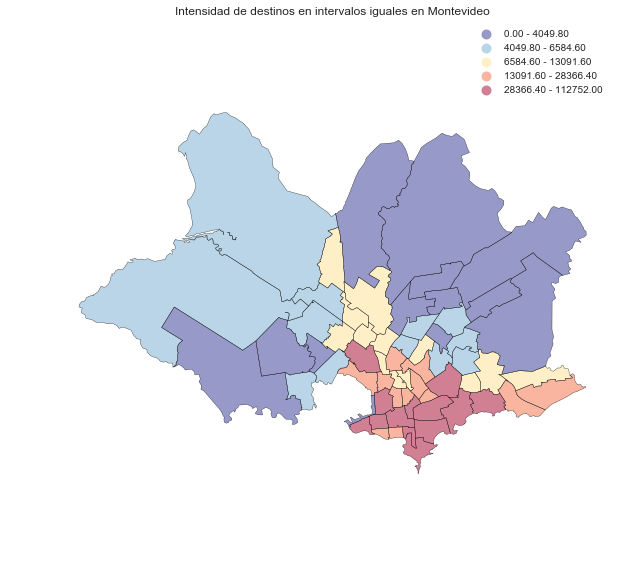

In [40]:
from matplotlib import colors
cmap10 = colors.ListedColormap(['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8', '#fee090','#fdae61','#f46d43','#d73027','#a50026'])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot the equal interval choropleth and add a legend
barrios.plot(column='Busquedas', scheme='fisher_jenks', legend=True, 
             ax=ax, cmap=cmap10, linewidth=0.3)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Intensidad de destinos en intervalos iguales en Montevideo")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

---
**Quintiles - 10 colores**

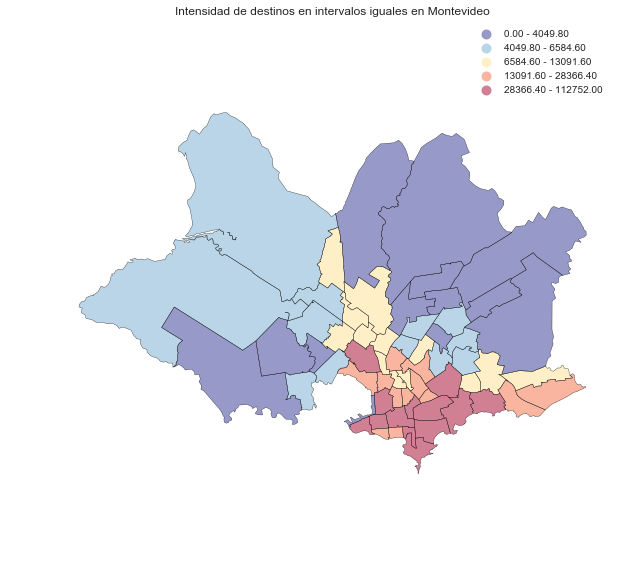

In [40]:
from matplotlib import colors
cmap10 = colors.ListedColormap(['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8', '#fee090','#fdae61','#f46d43','#d73027','#a50026'])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot the equal interval choropleth and add a legend
barrios.plot(column='Busquedas', scheme='quantiles', legend=True, 
             ax=ax, cmap=cmap10, linewidth=0.3)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Intensidad de destinos en intervalos iguales en Montevideo")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

---
**Fisher Jenks - 5 colores**

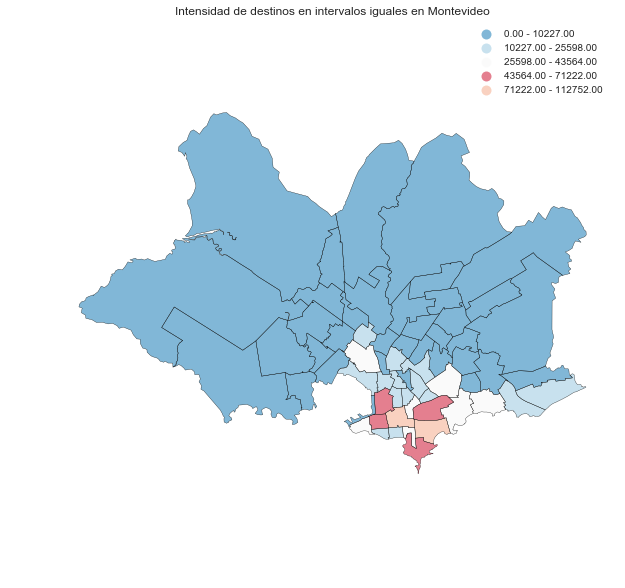

In [43]:
cmap5 = colors.ListedColormap(['#0571b0', '#92c5de','#f7f7f7','#ca0020','#f4a582'])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot the equal interval choropleth and add a legend
barrios.plot(column='Busquedas', scheme='fisher_jenks', legend=True, 
             ax=ax, cmap=cmap5, linewidth=0.3)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Intensidad de destinos en intervalos iguales en Montevideo")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

---
**Quintiles - 5 colores**

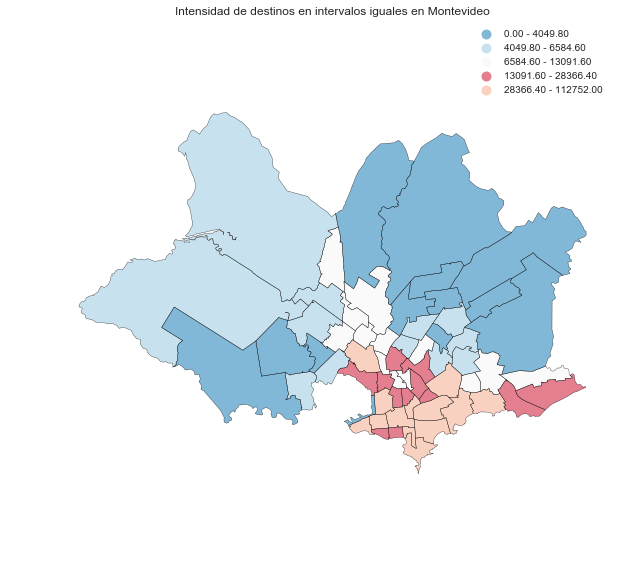

In [42]:
cmap5 = colors.ListedColormap(['#0571b0', '#92c5de','#f7f7f7','#ca0020','#f4a582'])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot the equal interval choropleth and add a legend
barrios.plot(column='Busquedas', scheme='Quantiles', legend=True, 
             ax=ax, cmap=cmap5, linewidth=0.3)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Intensidad de destinos en intervalos iguales en Montevideo")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

In [22]:
#['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
#['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
b201x = np.array(barrios.Busquedas)
bins_qk = ps.Quantiles(b201x, k=10)
colorsk = ['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#fee090','#fdae61','#f46d43','#d73027','#a50026']#['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
colors = [colorsk[i] for i in bins_qk.yb]

In [23]:
def gpd_bokeh(df):
    """Convert geometries from geopandas to bokeh format"""
    nan = float('nan')
    lons = []
    lats = []
    for i,shape in enumerate(df.geometry.values):
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)
                
        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 

    return lons,lats

In [24]:
lons, lats = gpd_bokeh(barrios)

In [25]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource

In [26]:
source = ColumnDataSource(data=dict(
        x=lons,
        y=lats,
        color=colors,
        name=barrios.BARRIO,
        rate=b201x
    ))

TOOLS = "pan, wheel_zoom, box_zoom, reset, hover, save"
p = figure(title="Movilidad Urbana Como Ir (" + str(AÑO) + ")", tools=TOOLS,
          plot_width=900, plot_height=600)

p.patches('x', 'y', source=source,
         fill_color='color', fill_alpha=0.7,
         line_color='white', line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [
    ("Barrio", "@name"),
    ("Busquedas", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]


output_file("comoir" + str(AÑO) + ".html", title="comoir" + str(AÑO) + ".py example")
show(p)